# COMP90051 Project 1

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

The base `SVM` class below defines a common interface for a support vector machine. 
Your implementations below for each part of the project should inherit from this class. Feel free to add to this class if you need.

In [129]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""
    
    def __init__(self) -> None:
        pass
        
    @abstractmethod
    def fit(self, X, y) -> None:        
        """Fit the model with the given training data.
        
        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """
    
    @abstractmethod
    def predict(self, test_X) -> int:
        """Predict label for given test samples

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 

        -------
        Return 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """
        
    def evaluate(self, test_X, test_y) -> int:
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """
            
        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc
    
    def visualize(self, X, y) -> None:
        """Plot data and decision surface of fitted model. 
        This function is adapted from 
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)
        
        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"
        
        def make_meshgrid(x, y, h=.02):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out
        
        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

### Binary classification data
First, we will generate some toy binary classification data, re-using the code from workshop 4. This will be used for parts 1-3, and the start of part 4.

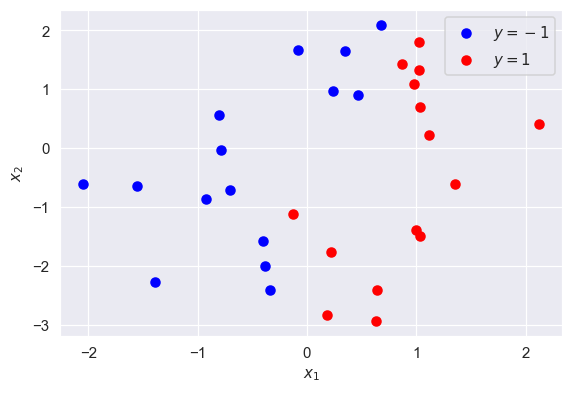

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
y = np.where(y <=0, -1, 1)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Part 1: Primal soft-margin SVM

In [240]:
class PrimalSVM(SVM):
    """Soft-margin SVM fit using primal objective, training 
    with stochastic gradient ascent.

    Parameters
    ----------
    eta : float
        Learning rate.
    lambda0: float
        Regularisation term, must be strictly positive
    """
    
    def __init__(self, eta, lambda0) -> None:
        super().__init__()
        ## your code here
        self.learn_rate = eta
        self.lambda0 = lambda0 
        self.weight = None
        self.bias = None
        
        ### end of your code ###
        
    def fit(self, X, y, iterations = 100) -> None:
        super().fit(X=X,y=y)
        ## your code here ###
        instances , features = X.shape
        self.bias = 0
        self.weight = np.zeros((features,1)) #prevent the transform problem
        
        for i in range(iterations):
            for ins in range(instances):
                ins_x = X[ins].reshape((1,features))
                ins_y = y[ins]
                
                if ins_y*(np.dot(ins_x,self.weight)+self.bias)>=1:
                    self.weight = self.weight-self.learn_rate*self.lambda0*self.weight
                else:
                    self.weight = self.weight-self.learn_rate*self.lambda0*self.weight+(ins_y*ins_x).T
                    self.bias = self.bias+self.learn_rate*ins_y
        ### end of your code ###
        
            
    def predict(self, test_X) -> int: 
        super().predict(test_X = test_X)
        ## your code here ###
        # np.sign can show the value is positive or negative
        result = np.sign(np.dot (test_X,self.weight)+self.bias).T
        return result
        ### end of your code ###

Accuracy is 0.9333


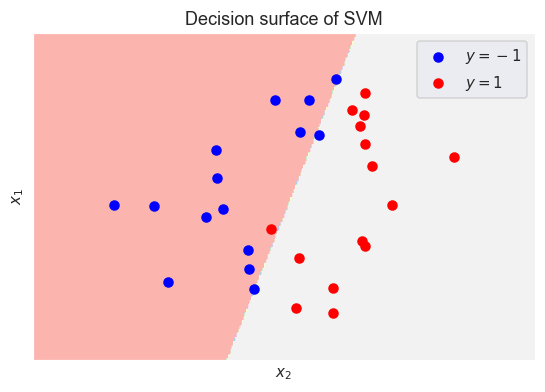

In [241]:
psvm = PrimalSVM(eta = 0.1, lambda0=0.1)
psvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")
psvm.visualize(X,y)

### Tuning lambda value

0.00018329807108324357


0.9667

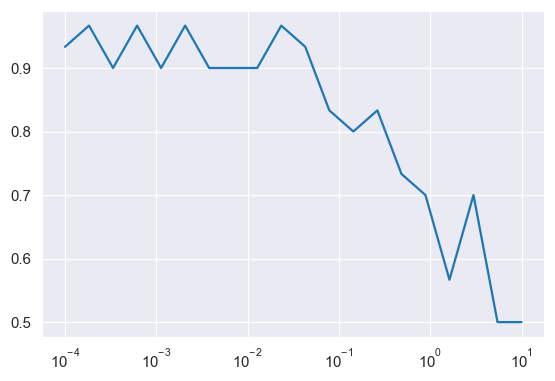

In [274]:
# Use this cell for experimentation 1.b
import math
lambda_val = np.logspace(-4,1,20)
acc_l = []
for lam in lambda_val:
    psvm = PrimalSVM(eta = 0.1, lambda0=lam)
    psvm.fit(X,y, iterations = 100)
    acc_l.append(round(psvm.evaluate(X,y),4))

plt.plot(lambda_val,acc_l)
plt.xscale('log')
print(lambda_val[np.argmax(acc_l)])
max(acc_l)

## Part 2: Dual soft-margin SVM

In [308]:
class DualSVM(SVM):
    """Soft-margin SVM using dual formulation, training 
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """
    
    def __init__(self, eta, C, kernel = None):
        super().__init__()
        if kernel is None:
            def dot_product(u,v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel
            
        ## your code here ###
        self.alphas = None
        self.learn_rate = eta
        self.weight = None
        self.bias = None
        self.C = C
        
        ### end of your code ###
    
    def fit(self, X, y, iterations = 100):
        
        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        
        ### your code here ###
        instances , features = X.shape
        self.alphas = np.zeros(instances) # lagrange multipliers (sometimes denoted lambda), you should initialize with 0s
        
        
        shad = np.random.permutation(instances)
        self.X = self.X[shad]
        self.y = self.y[shad]
        
        
        ker_matrix = self.kernel(self.X,self.X)
        
        
        for i in range(iterations):
            for ins in range(instances):
                sigmas = np.dot(self.alphas*self.y,ker_matrix)
                self.alphas += self.learn_rate * (1-self.y*sigmas)
                for alph in range(len(self.alphas)):
                    if self.alphas[alph] < 0:
                        self.alphas[alph] = 0
                    elif self.alphas[alph] >self.C:
                        self.alphas[alph] = self.C
        ### end of your code ###
        self.bias = self.get_bias()
            
        return 
     
    def predict(self, test_X):
        super().predict(test_X =test_X)
        ### your code here ###
        
        ker_matrix = self.kernel(self.X,test_X)
        
        return np.where((self.bias +np.dot(self.alphas*self.y,ker_matrix))>=0,1,-1)
        ### end of your code ###
    
    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel
        """
        ### your code here ###
        result = np.dot(self.alphas*self.y,self.X)
        return result
        ### end of your code ###
        
    def get_bias(self):
        """Compute bias based on learned alphas and training data set
        """
        ### your code here ###
        ker_matrix = self.kernel(self.X,self.X)
        
        
        all_esti = np.dot(self.alphas*self.y,ker_matrix)
        result = np.mean(self.y-all_esti)
        return result
        ### end of your code ###

Accuracy is 0.5


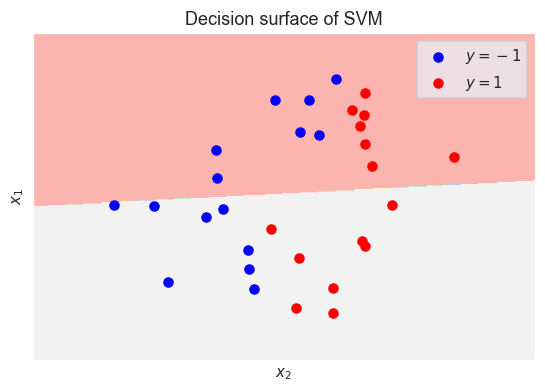

In [309]:
dsvm = DualSVM(eta = 0.1, C = 100)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

### Tuning C value

0.9667


0.02631578947368421

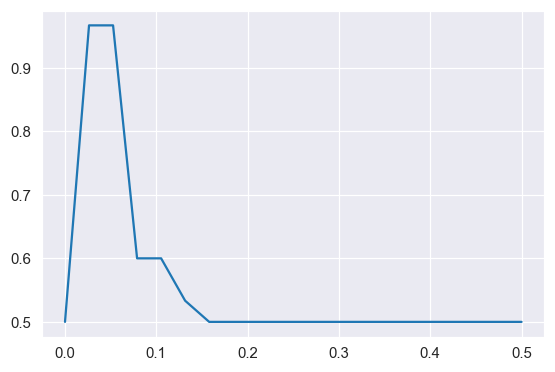

In [238]:
# Use this cell here for experimentation 2.a
c_val = np.linspace(0,0.5,20)
acc_c = []
for c in c_val:
    dsvm = DualSVM(eta = 0.1, C = c)
    dsvm.fit(X,y, iterations = 100)
    acc_c.append(round(dsvm.evaluate(X,y),4))

plt.plot(c_val,acc_c)
print(max(acc_c))
print(c_val[np.argmax(acc_c)])

### Compare weights between primal and dual

In [279]:
# Use this cell here for experimentation 2.b
from numpy.linalg import norm
d_w = dsvm.primal_weights()
p_w = psvm.weight.reshape(2)
norm_d = norm(dsvm.primal_weights())
norm_p = norm(psvm.weight.reshape(2))
result = norm(d_w/norm_d - p_w/norm_p)
result
# you can see that the norm is less than 1 , so that it means the vector weight is close 

0.29890858284304067

### Identify support vectors and points where alpha=C

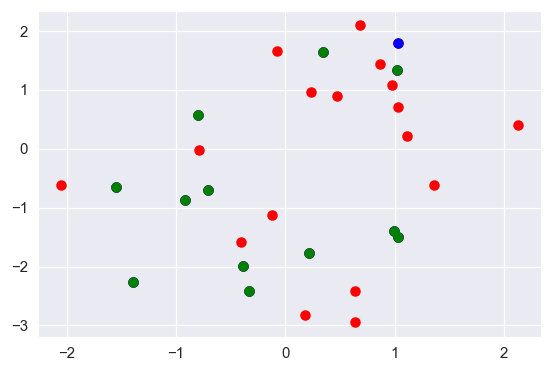

In [282]:
# Use this cell here for experimentation 2.c

ide_s = np.where(dsvm.alphas !=0)[0]
ide_c = np.where(dsvm.alphas == dsvm.C)[0]

plt.scatter(X[:,0],X[:,1],color = 'r')
plt.scatter(X[ide_s,0],X[ide_s,1],color = 'b')
plt.scatter(X[ide_c,0],X[ide_c,1],color = 'g')
# the green dot is the alphas equals to C

## Part 3: Kernel

In [310]:
from numpy.linalg import norm

    
class Kernel():
    """Kernel class

    Parameters
    ----------
    kernel_type : str {linear, poly, rbf}
        Type of kernel be indicated.
    poly_degree: int
        Polynomial degree for polynormial kernel. 
    poly_offset: float
        Polynomial offset for polynomial kernel. 
    rbf_sigma: float
        Kernel coefficient for rbf kernel. 
    """
    
    def __init__(self, kernel_type = None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        if kernel_type == "poly":
            self.degree = kwargs.get('poly_degree')
            self.sigma = kwargs.get('poly_offset')
            self.kernel = self.poly_kernel
        if kernel_type == "rbf":
            self.sigma = kwargs.get('rbf_sigma')
            self.kernel = self.rbf_kernel
            
    def __call__(self,u,v):
        """Evaluate the kernel on a pair of inputs, possibly batched.
        Matrix input is comprised of instances as row vectors.

        Parameters
        ----------
        u: vector or matrix
            first instance(s), shape (n,) or (m,n)
        v: vector or matrix
            second instance(s), shape (n,) or (z,n)
        
        -------
        Return : Kernel matrix, float or shape(z,) or shape (m,z)

        """
        return self.kernel(u, v)
        
    def linear_kernel(self, u, v):
        return np.dot(u,v.T)

    def poly_kernel(self, u, v):
        ### your code here ###
        poly_dot = np.dot(u,v.T)
        result = (poly_dot+self.sigma)** self.degree
        return result
        ### end of your code ###

    def rbf_kernel(self, u, v):
        ### your code here ###
        norm_u = norm(u,axis = -1)**2
        norm_v = norm(v,axis = -1)**2
        ker = np.exp(-1/(2*self.sigma**2)* (norm_u.reshape(-1,1)+norm_v.reshape(1,-1)-2*np.dot(u,v.T)))
        return np.squeeze(ker)
        ### end of your code ###

### Test your kernel in the DualSVM

Accuracy is 0.5


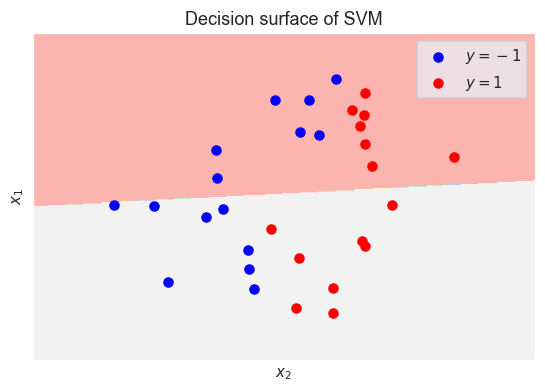

In [285]:
# Use this cell here for experimentation 3, e.g., 

svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('linear'))
svm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

Accuracy is 0.6333


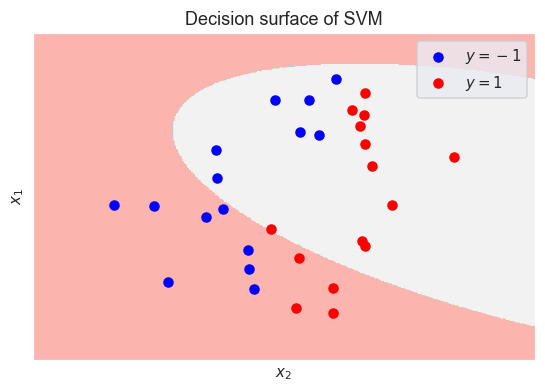

In [316]:

svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('poly',poly_degree = 2, poly_offset = 5))
svm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

Accuracy is 1.0


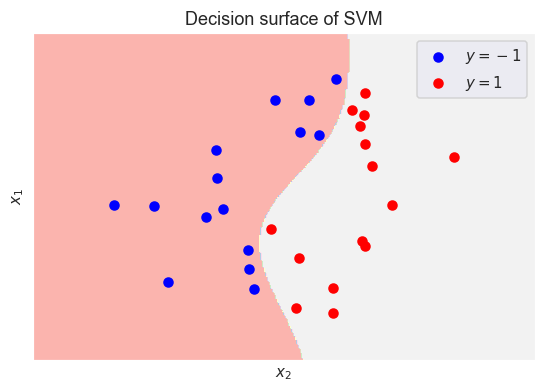

In [318]:
svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',rbf_sigma = 2))
svm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

Use this cell for your analysis for part 3.

so from the accuracy in 3 kernels, we can see that the rbf have highest accuracy which is 1.
in addition, in the graph, we can see the margin is close to y =1 and y = -1, also it may not have overfitting because of the margin is not only include the range with dots。

## Part 4: SMO

In [323]:
def random_pairs_heuristic(svm):
    for i2 in range(svm.n_samples):
        i1 = random.randint(0,svm.n_samples-1)
        yield (i1, i2)

def all_pairs_heuristic(svm):
    for i2 in range(svm.n_samples):
        for i1 in range(i2+1, svm.n_samples):
            yield (i1, i2)
    
class SMO(SVM):    
    def __init__(self, C, eps, tol, kernel, heuristic = all_pairs_heuristic):
        super().__init__()
        """Soft-margin SVM using dual formulation, training with sequential minimal optimization 
        """
        self.C = C
        self.eps = eps
        self.tol = tol
        self.kernel = kernel
        self.heuristic = heuristic
        
    def fit(self, X, y, iterations = 100):

        """Fit function for training SVM
        
        Parameters
        ----------
        iterations: int
            Stop training after this many iterations, even if not converged.
        """

        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        self.b = 0
        self.alphas = np.zeros(X.shape[0])
        self.n_samples, self.n_features = X.shape
        self.K = self.kernel(self.X, self.X)
        self.update_errors()
        
        num_changed = 1
        complete_pass = False
        epoch = 1
        total_changed = total_examined = 0
        for epoch in tqdm.trange(iterations):
            num_changed = num_examined = 0
            if not complete_pass:
                to_visit = self.heuristic(self)
            else:
                # force a full pass over all pairs of points
                # if previous epoch had no updates, to confirm
                # that model has converged
                to_visit = all_pairs_heuristic(self)
            for i1, i2 in to_visit:
                if self.__take_step(i1, i2):
                    num_changed += 1
                num_examined += 1

            epoch += 1
            total_changed += num_changed
            total_examined += num_examined
            if complete_pass and num_changed == 0:
                break
            complete_pass = (num_changed == 0)            
            
        if complete_pass and num_changed == 0:
            print('converged, total changed', total_changed, 'examined', total_examined)
        else:
            print('not converged, total changed', total_changed, 'examined', total_examined)

        return
    
    def lower(self, i1, i2):
        ### your code here ###
        if self.y[i1] != self.y[i2]:
            return max(0,self.alphas[i2] -self.alphas[i1])
        else:
            return max(0,self.alphas[i2] +self.alphas[i1]- self.C)
        ### end of your code ###

    def higher(self, i1, i2):
        ### your code here ###
        if self.y[i1] != self.y[i2]:
            return min(self.C,self.C+self.alphas[i2]-self.alphas[i1])
        else:
            return min(self.C,self.alphas[i1]+self.alphas[i2])
        ### end of your code ###
    
    def update_errors(self):
        self.errors = np.dot(self.alphas * self.y, self.K) - self.b  - self.y    

    def __take_step(self, i1, i2):
        if (i1 == i2):
            return False
        
        # extract alphas for two instances and calculate errors
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        s = y1 * y2
        
        L = self.lower(i1, i2)
        H = self.higher(i1, i2)
        
        if L == H:
            return False
        
        
        ### your code here
        k11 = self.kernel(self.X[i1],self.X[i1]) # fill in 
        k12 = self.kernel(self.X[i1],self.X[i2]) # fill in
        k22 = self.kernel(self.X[i2],self.X[i2]) # fill in
        eta = k11+k22-2*k12 # fill in
        if eta <= 0: 
            return False # we will ignore this corner case
    
        new_a2 = alpha2+y2*(E1-E2)/eta # fill in
        if new_a2 <L:
            new_a2 =L
        elif new_a2 >H:
            new_a2 =H
        ### end of your code
                    
        if abs(new_a2-alpha2) < self.eps * (new_a2 + alpha2 + self.eps):
            return False
        
        # update alphas, bias and errors
        new_a1 = alpha1 + s * (alpha2 - new_a2)
        self.b = self.update_bias(new_a1, new_a2,  i1, i2, k11, k12, k22)
        self.update_errors()
        self.alphas[i1] = new_a1
        self.alphas[i2] = new_a2
        
        return True

    def update_bias(self, new_a1, new_a2, i1, i2, k11, k12, k22):
        
        # extract alphas for two instances and calculate errors
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        
        ### your code here ###
        b_1 = E1+y1*(new_a1-alpha1)*k11+y2*(new_a2-alpha2)*k12+self.b
        b_2 = E2+y1*(new_a1-alpha1)*k12+y2*(new_a2-alpha2)*k22+self.b
        
        if alpha1 >0 and alpha1< self.C:
            return b_1
        elif alpha2 >0 and alpha1< self.C:
            return b_2
        else:
            return (b_1+b_2)/2
            
        ### end of your code ###
    
    def predict(self, test_X):
        super().predict(test_X =test_X)
        ### your code here ###
        ker_matrix = self.kernel(self.X,test_X)
        return np.where((self.b +np.dot(self.alphas*self.y,ker_matrix))>=0,1,-1)
        ### end of your code ###   
    

  6%|██▌                                       | 6/100 [00:00<00:00, 135.02it/s]


converged, total changed 84 examined 3045
Accuracy is 0.7333


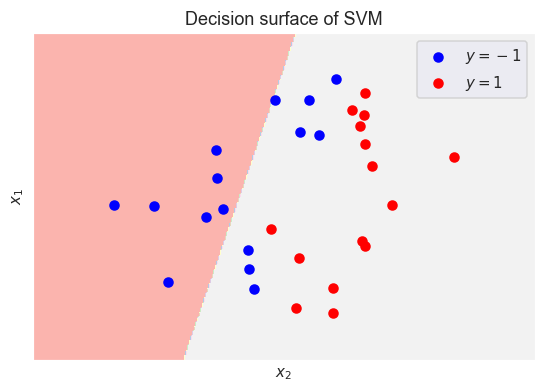

In [324]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'))
svm.fit(X,y,iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

 20%|████████▏                                | 20/100 [00:00<00:00, 121.01it/s]


converged, total changed 383 examined 9135
Accuracy is 0.8


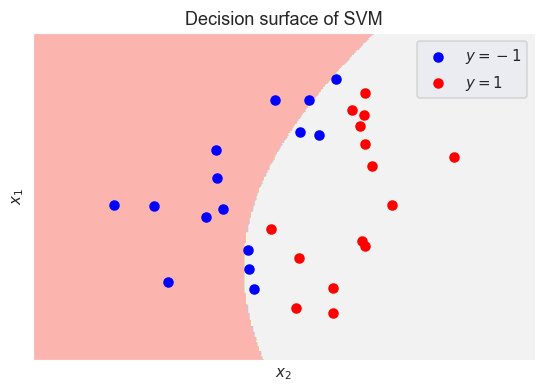

In [327]:
# Use this cell here for experimentation 4.a
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('poly',poly_degree = 2, poly_offset = 5))
svm.fit(X,y,iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

 10%|████▏                                     | 10/100 [00:00<00:04, 20.21it/s]


converged, total changed 221 examined 4785
Accuracy is 0.9333


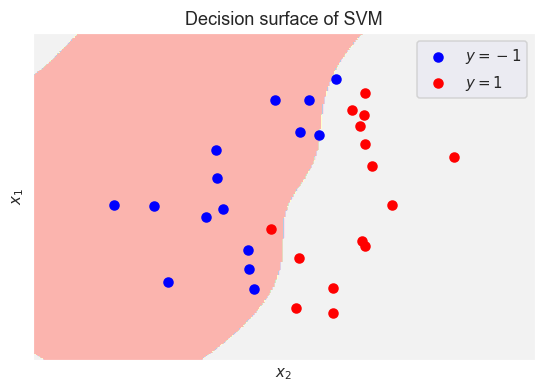

In [329]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('rbf',rbf_sigma = 1))
svm.fit(X,y,iterations = 100)
print(f"Accuracy is {round(svm.evaluate(X,y),4)}")
svm.visualize(X,y)

### Fashion MNIST dataset and heuristic functions

The code below loads a part of the fashion-MNIST dataset, comprising pictures of clothing. The challenge is to classify the clothing by type. We have taken just two classes.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


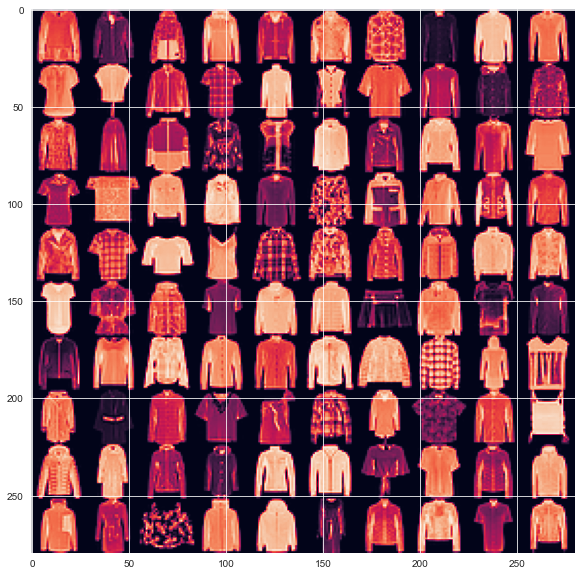

In [331]:
# extract a stack of 28x28 bitmaps
from sklearn.model_selection import train_test_split
%pylab inline

pics = np.loadtxt('train.csv', delimiter=' ')
Xf = pics[:, 0:784]
Xf = np.array([i/255 for i in Xf])

# extract labels for each bitmap
yf = pics[:, 784:785]
yf = np.array([int(i[0]) for i in yf])

# display a sample of the data
def gallery(array, ncols):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    result = (array.reshape((nrows, ncols, height, width))
              .swapaxes(1,2)
              .reshape((height*nrows, width*ncols)))
    return result

ncols = 10
result = gallery(Xf.reshape((1200, 28, 28))[:ncols**2], ncols)
plt.figure(figsize=(10,10))
plt.imshow(result, interpolation=None)

# split data into a modest size training set, reserving the rest for testing
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=600, random_state=RND_SEED)

In [413]:
# Use this cell here for experimentation 4.b
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'))
svm.fit(X_train,y_train,iterations = 200)
print(f"SMO evaluate Accuracy is {round(svm.evaluate(X_test,y_test),4)}")
print(f"SMO train Accuracy is {round(svm.evaluate(X_train,y_train),4)}")

 94%|██████████████████████████████████████▎  | 187/200 [07:35<00:31,  2.44s/it]

converged, total changed 44260 examined 33783600
SMO evaluate Accuracy is 0.6017
SMO train Accuracy is 0.6067


In [341]:
svm = DualSVM(eta = 0.1, C = 100, kernel = Kernel('rbf',rbf_sigma = 2))
svm.fit(X_train,y_train, iterations = 100)
print(f"DualSVMevaluate Accuracy is {round(svm.evaluate(X_test,y_test),4)}")
print(f"DualSVM train Accuracy is {round(svm.evaluate(X_train,y_train),4)}")

DualSVMevaluate Accuracy is 0.8483
DualSVM train Accuracy is 1.0


In [342]:
psvm = PrimalSVM(eta = 0.1, lambda0=0.1)
psvm.fit(X_train,y_train, iterations = 100)
print(f"PrimalSVM evaluate Accuracy is {round(psvm.evaluate(X_test,y_test),4)}")
print(f"PrimalSVM train Accuracy is {round(psvm.evaluate(X_train,y_train),4)}")

PrimalSVM evaluate Accuracy is 0.65
PrimalSVM train Accuracy is 0.6683


In [394]:
def my_heuristic(svm):
    """A heuristic function of selecting which instance pairs 
    to process (with __take_step) over a single SMO epoch. 

    Parameters
    ----------
    svm : SMO class
    ----------
    Return
    list of (int, int) tuples, the indices for pairs of training instances
    """
    ### your code here ###
    #for i2 in range(svm.n_samples):
     #   for i1 in range(i2+1, svm.n_samples):
      #      i_u = svm.n_samples - i1
       #     yield (i_u, i2)
    delta_h = 0
    h_j = 0
    for i in range(svm.n_samples):
        if (svm.y[i]*svm.errors[i] > svm.tol and svm.alphas[i]> 0):
            for j in range(i+1, svm.n_samples):
                delta = svm.errors[i] - svm.errors[j]
                if abs(delta) > delta_h:
                    delta_h = delta
                    h_j = j
            yield(i,h_j)
        elif (svm.y[i]*svm.errors[i]< -svm.tol and svm.alphas[i] <svm.C):
            for j in range(i+1, svm.n_samples):
                delta = svm.errors[i] - svm.errors[j]
                if abs(delta) > delta_h:
                    delta_h = delta
                    h_j = j
            yield(i,h_j)
            
    ### end of your code ###

In [411]:
# Use this cell here for experimentation 4.c 
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'), heuristic = my_heuristic)
svm.fit(X_train,y_train,iterations = 400)
print(f"SMO evaluate Accuracy is {round(svm.evaluate(X_test,y_test),4)}")

 91%|█████████████████████████████████████▏   | 363/400 [07:14<00:44,  1.20s/it]

converged, total changed 43657 examined 32388041
SMO evaluate Accuracy is 0.6017


In [410]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'), heuristic = random_pairs_heuristic)
svm.fit(X_train,y_train,iterations = 1300)
print(f"SMO evaluate Accuracy is {round(svm.evaluate(X_test,y_test),4)}")

 81%|███████████████████████████████▍       | 1047/1300 [05:40<01:22,  3.08it/s]

converged, total changed 32768 examined 26061000
SMO evaluate Accuracy is 0.6017


In [407]:
svm = SMO(C = 1,eps = 0.01,tol = 0.001,kernel = Kernel('linear'), heuristic = all_pairs_heuristic)
svm.fit(X_train,y_train,iterations = 200)
print(f"SMO evaluate Accuracy is {round(svm.evaluate(X_test,y_test),4)}")

 94%|██████████████████████████████████████▎  | 187/200 [07:27<00:31,  2.39s/it]

converged, total changed 44260 examined 33783600
SMO evaluate Accuracy is 0.6017


we can see that the if it is converged, the accuracy is the same, but the random_pairs_heuristic need 1047 iteration to converged,  the all_pairs_heuristic only need 187 iterations, and my_heuristic is 363 iterations but the speed of converged is fastest in 3 methods
